In [1]:
import os

import imghdr
import cv2

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras import regularizers

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imghdr

import imagesize
from PIL import Image

%config Completer.use_jedi = False

In [2]:
accepted_image_formats = ['bmp', 'jpg', 'jpeg', 'png']

for image_directory in os.listdir('images_for_binary'):
    i = 0
    cwd = os.path.join('images_for_binary', image_directory)
    for image_filename in os.listdir(os.path.join('images_for_binary', image_directory)):
        image_path = os.path.join('images_for_binary', image_directory, image_filename)
        
        filename_fragments = image_filename.split(sep='.')
        image_format = filename_fragments.pop()
        
        if image_format not in accepted_image_formats:
            try:
                im = Image.open(image_path)
                im.verify()
                im = Image.open(image_path).convert('RGB')
                im.save(f"{cwd}\\{str(i)}.jpeg")
                
                print(f"{image_path} was converted successfully.")
                
                image_filename = str(i)
                image_path = cwd + '\\' + str(i) + ".jpeg"
                i = i + 1
                im.close()
    
            except Exception:
                print("{} is a corrupt image and will be removed.".format(image_path))
                os.remove(image_path)
                continue
            
        file_size = os.stat(image_path).st_size / 1024
        
        width, height = imagesize.get(image_path)
        aspect_ratio = max(width, height) / min(width, height)
        
        if image_format in accepted_image_formats:
            try:
                image = cv2.imread(image_path) 
            except Exception:
                print("File {} could not be opened and will be removed.".format(image_path))
                os.remove(image_path)
                print("{} is removed.".format(image_path))
                continue
        else:
            print("Invalid image: {}".format(image_path))
            #os.remove(image_path)
            print("{} is removed.".format(image_path))

images_for_binary\cars_cats\cars is a corrupt image and will be removed.


PermissionError: [WinError 5] A hozzáférés megtagadva: 'images_for_binary\\cars_cats\\cars'

In [141]:
directory = os.path.join('../images_for_binary', 'cars_cats_kaggle')
data = tf.keras.preprocessing.image_dataset_from_directory(directory, batch_size=32, image_size=(128, 128))

Found 1296 files belonging to 2 classes.


In [142]:
iterator = data.as_numpy_iterator()

In [143]:
batch = iterator.next()

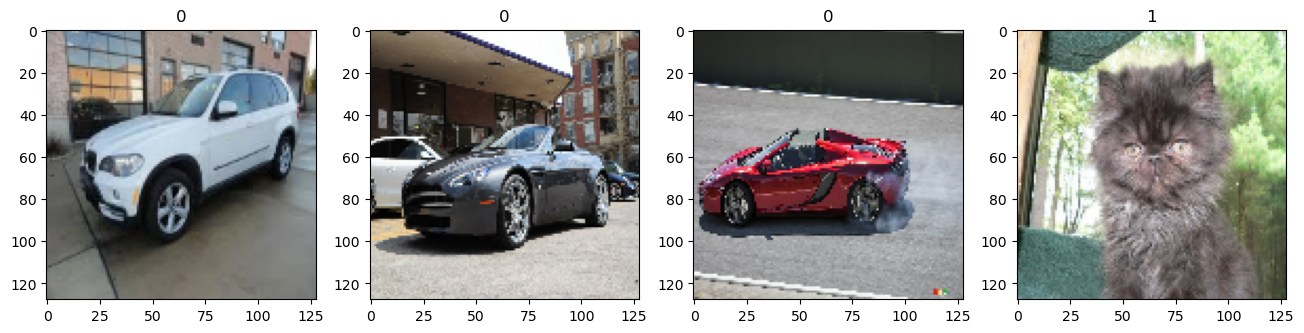

In [144]:
figure, ax = plt.subplots(ncols=4, figsize=(16, 16))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [145]:
data = data.map(lambda x, y: (x / 255, y))
scaled_iterator = data.as_numpy_iterator()

In [146]:
batch_count = len(data)
train_size = int(batch_count * 0.7)
test_size = int(batch_count * 0.2)
validation_size = int(batch_count * 0.1)

In [147]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)
validation_data = data.skip(train_size).skip(test_size).take(validation_size)

In [221]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, input_shape=(128,128,3), activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation = "relu" ))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = 'sigmoid'))

In [225]:
model.compile('adam', loss="binary_crossentropy", metrics=['accuracy'])

In [226]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 63504)             0         
                                                                 
 dense_42 (Dense)            (None, 64)                4064320   
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                     

In [227]:
log_directory = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory, histogram_freq=1)

In [228]:
hist = model.fit(train_data, epochs=5, validation_data=validation_data, callbacks=[tensorboard_callback])

Epoch 1/5
28/28 [==============================] - 5s 169ms/step - loss: 1.0600 - accuracy: 0.6350 - val_loss: 0.3476 - val_accuracy: 0.8828
Epoch 2/5
28/28 [==============================] - 5s 171ms/step - loss: 0.2547 - accuracy: 0.9141 - val_loss: 0.2293 - val_accuracy: 0.9141
Epoch 3/5
28/28 [==============================] - 5s 171ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 0.3140 - val_accuracy: 0.8750
Epoch 4/5
28/28 [==============================] - 5s 168ms/step - loss: 0.1327 - accuracy: 0.9598 - val_loss: 0.1473 - val_accuracy: 0.9531
Epoch 5/5
28/28 [==============================] - 5s 174ms/step - loss: 0.0794 - accuracy: 0.9777 - val_loss: 0.1194 - val_accuracy: 0.9531


In [229]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()

In [231]:
for batch in test_data.as_numpy_iterator():
    x, y = batch
    one_hot_y = tf.one_hot(indices=y, depth=2)
    yhat = model.predict(x)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [232]:
print("Precision: {}".format(precision.result().numpy()))
print("Recall: {}".format(recall.result().numpy()))
print("Accuracy: {}".format(accuracy.result().numpy()))

Precision: 0.9916666746139526
Recall: 0.9224806427955627
Accuracy: 0.95703125


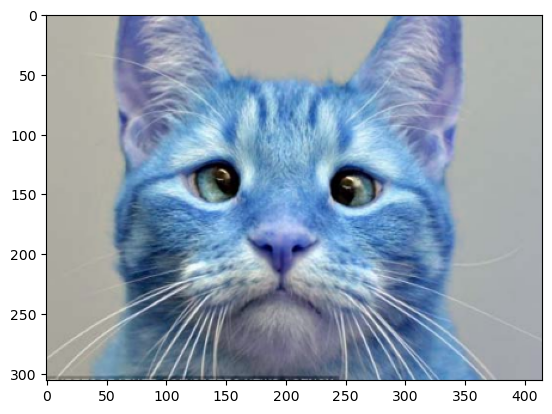

In [311]:
test_image = cv2.imread('test_images/04.PNG')
plt.imshow(test_image)
plt.show()

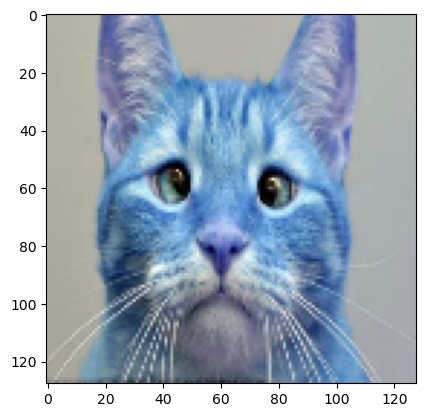

In [312]:
resized_image = tf.image.resize(test_image, (128, 128))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [313]:
yhat = model.predict(np.expand_dims(resized_image / 255, 0))

In [314]:
print(yhat)

[[0.01003072]]
